In [4]:
from pyhaystack.client.niagara import NiagaraHaystackSession
import pandas as pd


session = NiagaraHaystackSession(uri='http://192.168.60.5', username='Balancer', password='Balancer12345', pint=True)

op = session.nav()
op.wait()
nav = op.result
print(nav)

<Grid>
	Columns:
		dis
		navId
	Row    0: dis='ComponentSpace', navId='slot:/'
	Row    1: dis='HistorySpace', navId='his:/'
	Row    2: dis='Site', navId='sep:/'
</Grid>


In [8]:
hws = session.find_entity(filter_expr='hotWaterSupplyES').result
hws_df = session.his_read_frame(hws, rng= '2017-09-01,2018-02-12').result
hws = pd.Series(hws_df[hws_df.columns[0]])

hwr = session.find_entity(filter_expr='hotWaterReturnES').result
hwr_df = session.his_read_frame(hwr, rng= '2017-09-01,2018-02-12').result
hwr = pd.Series(hwr_df[hwr_df.columns[0]])

oat = session.find_entity(filter_expr='outsideAirES').result
oat_df = session.his_read_frame(oat, rng= '2017-09-01,2018-02-12').result
oat = pd.Series(oat_df[oat_df.columns[0]])



data = pd.DataFrame({'hws' : hws, 'hwr' : hwr, 'oat' : oat})


data.index.names=['Date']

print(data.head())
print(data.tail())

                                       hwr       hws      oat
Date                                                         
2017-09-01 00:00:06.617000-05:00       NaN  128.1814      NaN
2017-09-01 00:00:06.640000-05:00  130.4667       NaN      NaN
2017-09-01 00:00:06.674000-05:00       NaN       NaN  52.0743
2017-09-01 00:15:06.824000-05:00       NaN  134.8607      NaN
2017-09-01 00:15:06.842000-05:00  129.4649       NaN      NaN
                                       hwr       hws      oat
Date                                                         
2018-02-12 23:30:07.021000-06:00  151.3397       NaN      NaN
2018-02-12 23:30:07.055000-06:00       NaN       NaN  10.7926
2018-02-12 23:45:07.448000-06:00       NaN  161.0854      NaN
2018-02-12 23:45:07.477000-06:00  155.2778       NaN      NaN
2018-02-12 23:45:07.525000-06:00       NaN       NaN  10.3933


In [11]:
data = data.fillna(method = 'ffill').fillna(method = 'bfill')

print(data.head())
print(data.tail())

                                       hwr       hws      oat
Date                                                         
2017-09-01 00:00:06.617000-05:00  130.4667  128.1814  52.0743
2017-09-01 00:00:06.640000-05:00  130.4667  128.1814  52.0743
2017-09-01 00:00:06.674000-05:00  130.4667  128.1814  52.0743
2017-09-01 00:15:06.824000-05:00  130.4667  134.8607  52.0743
2017-09-01 00:15:06.842000-05:00  129.4649  134.8607  52.0743
                                       hwr       hws      oat
Date                                                         
2018-02-12 23:30:07.021000-06:00  151.3397  160.6394  10.7595
2018-02-12 23:30:07.055000-06:00  151.3397  160.6394  10.7926
2018-02-12 23:45:07.448000-06:00  151.3397  161.0854  10.7926
2018-02-12 23:45:07.477000-06:00  155.2778  161.0854  10.7926
2018-02-12 23:45:07.525000-06:00  155.2778  161.0854  10.3933


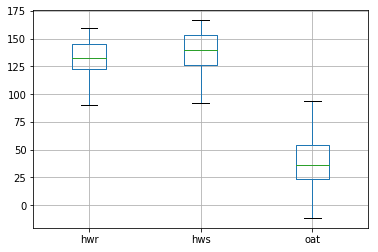

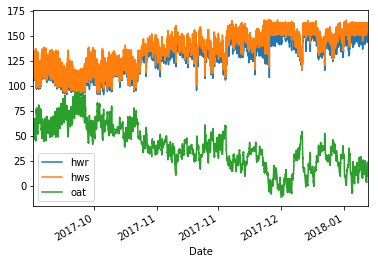

In [13]:
import matplotlib.pyplot as plt


data.boxplot()
plt.show()

data.plot()
plt.show()

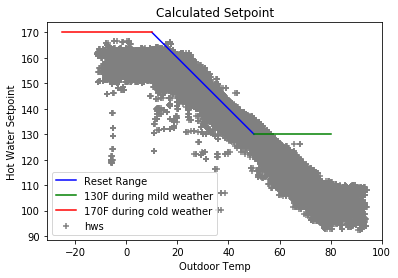

In [14]:
plt.scatter(data['oat'], data['hws'], color='grey', marker='+')

plt.plot([10,50],[170,130], color='blue', label='Reset Range')

plt.plot([50,80],[130,130], color='green', label='130F during mild weather')
plt.plot([-25,10],[170,170], color='red', label='170F during cold weather')

plt.xlabel('Outdoor Temp')
plt.ylabel('Hot Water Setpoint')
plt.title('Calculated Setpoint')

plt.legend()

plt.show()

In [15]:
import statistics as stats

#Pearsons Correlation Coefficient to find correlation between OAT & HWS, should be a strong negative correlation

#OAT
x = data['oat']

#HWS
y = data['hws']


# Create a function
def pearson(x,y):
    
    # Create n, the number of observations in the data
    n = len(x)
    
    # Create lists to store the standard scores
    standard_score_x = []
    standard_score_y = []
    
    # Calculate the mean of x
    mean_x = stats.mean(x)
    
    # Calculate the standard deviation of x
    standard_deviation_x = stats.stdev(x)
    
    # Calculate the mean of y
    mean_y = stats.mean(y)
    
    # Calculate the standard deviation of y
    standard_deviation_y = stats.stdev(y)

    # For each observation in x
    for observation in x: 
        
        # Calculate the standard score of x
        standard_score_x.append((observation - mean_x)/standard_deviation_x) 

    # For each observation in y
    for observation in y:
        
        # Calculate the standard score of y
        standard_score_y.append((observation - mean_y)/standard_deviation_y)

    # Multiple the standard scores together, sum them, then divide by n-1, return that value
    return (sum([i*j for i,j in zip(standard_score_x, standard_score_y)]))/(n-1)

pearson(x,y)

-0.94909531560942539

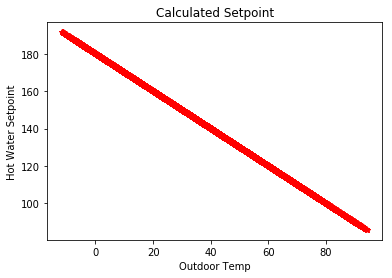

In [17]:
import numpy as np

A = np.matrix([[10,1],[50,1]])
B = np.matrix([[170],[130]])
A_inverse = np.linalg.inv(A)
X = A_inverse * B

T = data[('oat')]
line = np.vstack((T, np.ones(T.shape))).transpose().dot(X)

plt.xlabel('Outdoor Temp')
plt.ylabel('Hot Water Setpoint')
plt.title('Calculated Setpoint')
plt.plot(T, line, 'r*')
plt.show()

In [18]:
from statistics import mean
import numpy as np

X = data[('oat')]

def setpoint_calc(X):
    A = np.matrix([[10,1],[50,1]])
    B = np.matrix([[170],[130]])
    A_inverse = np.linalg.inv(A)
    X = A_inverse * B
    
    return X

setpoint_calc(X)

matrix([[  -1.],
        [ 180.]])

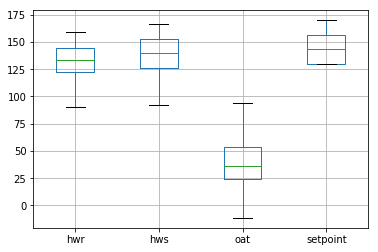

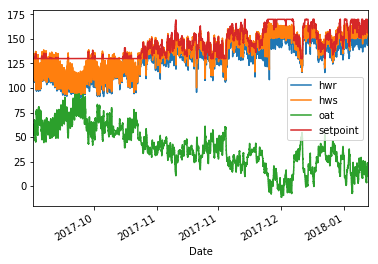

In [20]:
data['setpoint'] = data['oat'].apply(lambda x: -1 * x + 180)

data.loc[data['setpoint'] > 170, 'setpoint'] = 170

data.loc[data['setpoint'] < 130, 'setpoint'] = 130

data.boxplot()
plt.show()

data.plot()
plt.show()

In [21]:
#Use this below if there is a lockout setpoint to shut the boilers off in summer conditions else ignore if boiler run all year
#data = data.loc[data['oat'] < 50]

Series_setpoint = pd.Series(data['setpoint'])
 
Series_hws = pd.Series(data['hws'])

Deviation = Series_hws - Series_setpoint

In [22]:

def OUTput(x):
    if x > 10:
        return 'Too hot.'
    elif x < -10:
        return 'Too cool.'
    else:
        return 'Normal.'

In [23]:
data['PrintOut'] = Deviation.apply(OUTput)

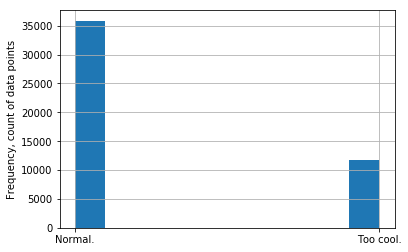

In [26]:
PrintOut = data['PrintOut']

plt.ylabel('Frequency, count of data points')

PrintOut.hist()
plt.show()

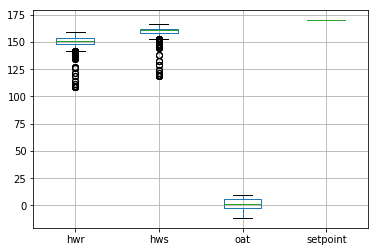

In [29]:
Designdata = data

Designdata = Designdata.loc[Designdata['oat'] < 10]

Designdata.boxplot()
plt.show()

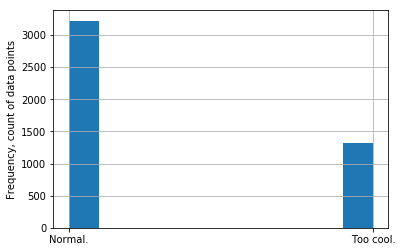

In [31]:
PrintOut = Designdata['PrintOut']

plt.ylabel('Frequency, count of data points')

PrintOut.hist()
plt.show()

In [32]:
deltaT = Designdata['hws'] - Designdata['hwr']

deltaT.name = 'DeltaT'

deltaT = deltaT.to_frame()

print(deltaT.head())

                                   DeltaT
Date                                     
2017-12-14 06:00:07.854000-06:00  12.4212
2017-12-14 06:15:07.678000-06:00  12.8941
2017-12-14 06:15:07.697000-06:00  13.8289
2017-12-14 06:15:07.744000-06:00  13.8289
2017-12-14 06:30:00.777000-06:00  12.6086


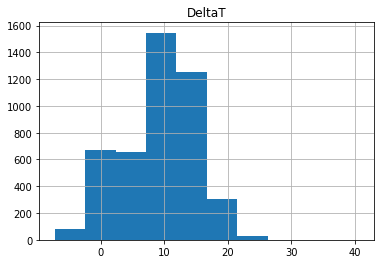

In [33]:
deltaT.hist()
plt.show()